In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diagnosis-of-diabetic-retinopathy:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4046394%2F7034146%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T171316Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5ed260ebbb53021620c749fe4498a56b6fd9a4de8e580300e0775eddd4c16749fadc73846a77baf0bdb36608d29ea2371fcaa4987e4c7c6605687753c3d11a00522a7ce35625894991572eb5e702cf59373ecca731238bd1cd9d88295d74e88bfcd4cff7877b9bbbd2e250abd6b7e475ef0600f04e3efb0fb7b75bfb963f57edf83bdd37994387031e447a02cc1c179e7ee335f8053bc94df4a84195007c3b3b4e96e6bca5bea76db1106a454daac30591b6bab86ba1db4f699298d329e6d12015f135d1d30e2acf7df3a60fa23aaa9113f552d0f9827f493f3f4da9927e81bdd9eaf8eeb518d829325825d43b3efc0d0e0178867b275f570fc84c80bcf2454f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15641051 bytes downloaded
Downloaded and uncompressed: diagnosis-of-diabetic-retinopathy
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Define dataset paths
train_path = "/kaggle/input/diagnosis-of-diabetic-retinopathy/train"
valid_path = "/kaggle/input/diagnosis-of-diabetic-retinopathy/valid"
test_path = "/kaggle/input/diagnosis-of-diabetic-retinopathy/test"

In [ ]:
# Define datasets
train_dataset = datasets.ImageFolder(train_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

In [ ]:
# Define dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define visualization function
def visualize_samples(loader, class_labels):
    figure = plt.figure(figsize=(12, 12))
    cols, rows = 4, 4
    for i in range(1, cols * rows + 1):
        sample_idx = np.random.randint(len(loader.dataset))
        img, label = loader.dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(class_labels[label])
        plt.axis("off")
        img_np = img.numpy().transpose((1, 2, 0))
        img_valid_range = np.clip(img_np, 0, 1)
        plt.imshow(img_valid_range)
    plt.show()

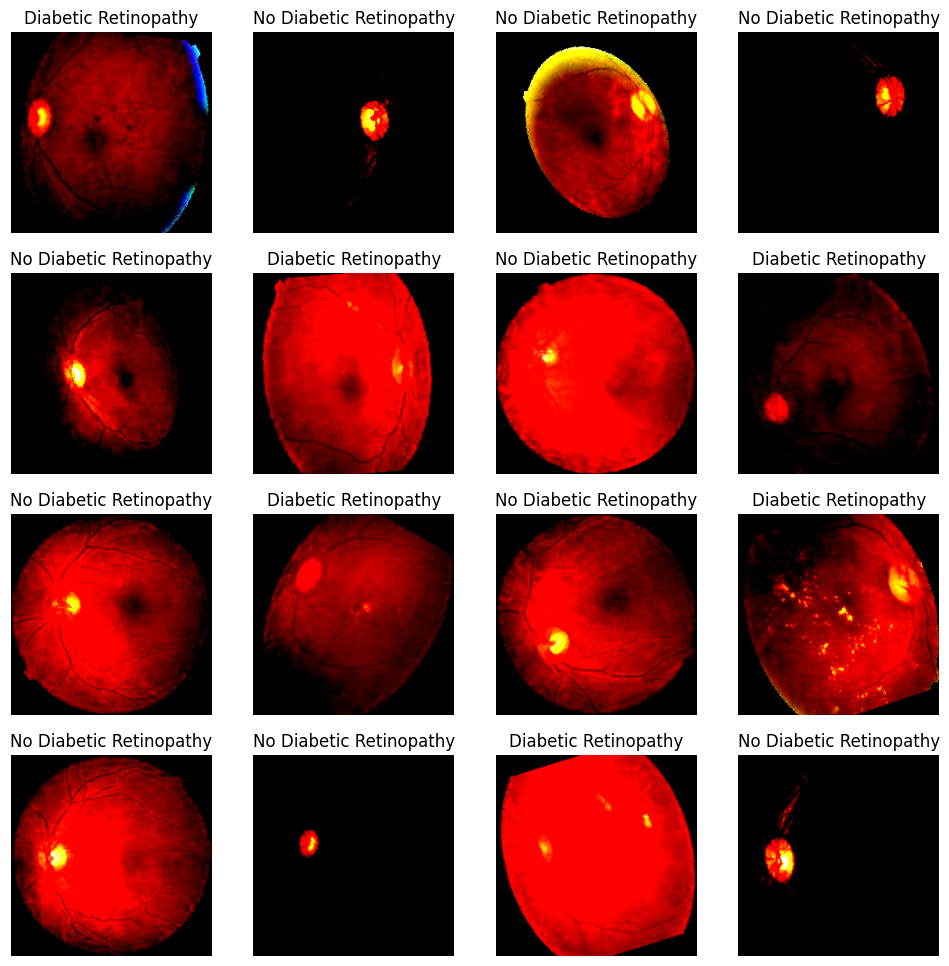

In [ ]:
# Visualize some training samples
class_labels = {0: 'Diabetic Retinopathy', 1: 'No Diabetic Retinopathy'}
visualize_samples(train_loader, class_labels)

In [ ]:
# Combine ResNet18 and GoogLeNet features
class TransferNet(nn.Module):
    def __init__(self, num_classes=2):
        super(TransferNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        googlenet = models.googlenet(pretrained=True)

        # Remove the last fully connected layer in both models
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])
        self.googlenet_features = nn.Sequential(*list(googlenet.children())[:-1])

        # Concatenate the features
        self.features = nn.Sequential(
            nn.Conv2d(512 + 1024, 512, kernel_size=1),  # Adjust the number of channels
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )

        # Adjust the number of input features for the fully connected layer
        num_features = 512  # Change this if needed
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x_resnet = self.resnet_features(x)
        x_googlenet = self.googlenet_features(x)
        x_combined = torch.cat([x_resnet, x_googlenet], dim=1)
        x = self.features(x_combined)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
# Create an instance of TransferNet
transfer_model = TransferNet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transfer_model = transfer_model.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

In [ ]:
# Training loop with transfer learning
def train_transfer_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(valid_loader.dataset)
        accuracy = correct_preds.double() / total_samples

        scheduler.step(avg_val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Accuracy: {accuracy:.4f}')

In [ ]:
# Train the transfer model
train_transfer_model(transfer_model, train_loader, valid_loader, criterion, optimizer, lr_scheduler, num_epochs=10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/10], Training Loss: 0.0031, Validation Loss: 0.0020, Accuracy: 0.9586


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/10], Training Loss: 0.0016, Validation Loss: 0.0014, Accuracy: 0.9661


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/10], Training Loss: 0.0013, Validation Loss: 0.0012, Accuracy: 0.9755


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/10], Training Loss: 0.0010, Validation Loss: 0.0010, Accuracy: 0.9812


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/10], Training Loss: 0.0010, Validation Loss: 0.0013, Accuracy: 0.9699


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/10], Training Loss: 0.0006, Validation Loss: 0.0011, Accuracy: 0.9699


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/10], Training Loss: 0.0008, Validation Loss: 0.0010, Accuracy: 0.9812


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/10], Training Loss: 0.0004, Validation Loss: 0.0012, Accuracy: 0.9736


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/10], Training Loss: 0.0007, Validation Loss: 0.0013, Accuracy: 0.9755


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/10], Training Loss: 0.0003, Validation Loss: 0.0011, Accuracy: 0.9755


In [ ]:
# Visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
# Evaluate the transfer model on the test set
def evaluate_transfer_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

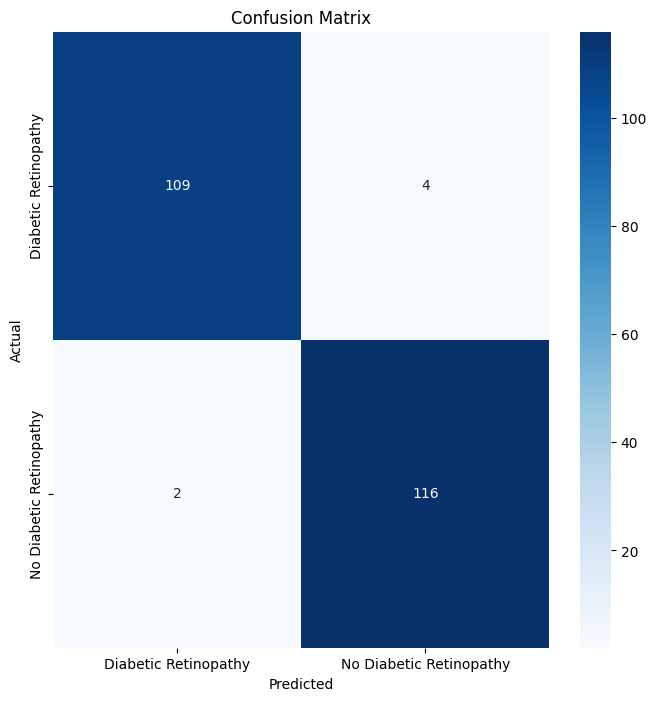

In [ ]:
# Plot confusion matrix
class_labels = {0: 'Diabetic Retinopathy', 1: 'No Diabetic Retinopathy'}
y_true, y_pred = evaluate_transfer_model(transfer_model, test_loader)
plot_confusion_matrix(y_true, y_pred, classes=list(class_labels.values()))

In [ ]:
# Save the transfer model
torch.save(transfer_model.state_dict(), "transfer_model.pth")

In [ ]:
# Load the saved transfer model
loaded_transfer_model = TransferNet()
loaded_transfer_model.load_state_dict(torch.load("transfer_model.pth"))
loaded_transfer_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date we

TransferNet(
  (resnet_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
# Make predictions on a sample image
def predict_single_image(model, image_path, transform):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
    return predicted_class, probabilities[0].cpu().numpy()

In [ ]:
# Example prediction
image_path = "/content/10084_left_fuse.png"
predicted_class, probabilities = predict_single_image(loaded_transfer_model, image_path, transform)
class_name = class_labels[predicted_class]
print(f"Predicted class: {class_name}, Probabilities: {probabilities}")

Predicted class: Diabetic Retinopathy, Probabilities: [0.88256365 0.11743636]


In [ ]:
def visualize_predicted_image(model, image_path, transform, class_labels):
    predicted_class, probabilities = predict_single_image(model, image_path, transform)
    class_name = class_labels[predicted_class]

    # Load and display the image
    img = Image.open(image_path).convert('RGB')
    plt.imshow(img)
    plt.title(f'Predicted Class: {class_name}\nProbabilities: {probabilities}')
    plt.axis('off')
    plt.show()

In [ ]:
# Example usage:
image_path = "/kaggle/input/diagnosis-of-diabetic-retinopathy/test/DR/00cb6555d108_png.rf.29cca170969c6e9918ef9b9209abef8e.jpg"
visualize_predicted_image(loaded_transfer_model, image_path, transform, class_labels)